In [1]:
import scanpy as sc
import squidpy as sq
import spatialdata as sd
import spatialdata_io as si
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
from spatialdata.models import ShapesModel
import spatialdata_plot
import cv2
from napari_spatialdata import Interactive
from spatialdata.transformations import (
    Affine,
    Identity,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    get_transformation_between_coordinate_systems,
    set_transformation,
)
from spatialdata.models import ShapesModel
from spatialdata.transformations import (
    align_elements_using_landmarks,
    get_transformation_between_landmarks,
)
from spatialdata import SpatialData
from spatialdata.transformations import (
    BaseTransformation,
    Sequence,
    get_transformation,
    set_transformation,
)

❗ You are running 3.11.3
Only python versions 3.7~3.10 are currently tested, use at your own risk.


# Load All data into list

In [2]:
datasets = ['LIB5472833_SAM24434294','LIB5472834_SAM24434295', 'LIB5472835_SAM24434296',
            'LIB5472836_SAM24434297','LIB5472837_SAM24434298','LIB5472838_SAM24434299']
data_list=[]
for dataset in datasets:
    data_list.append(sd.read_zarr(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}.zarr'))

In [3]:
# Read spot data to h5ad object so we can export to Seurat and scanpy later
x=0
spot_data=[]
for dataset in datasets:
    spot_data.append(sc.read_h5ad(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}_Spots.h5ad'))


In [4]:
x=0
for dataset in datasets:
    del data_list[x].table
    data_list[x].table= spot_data[x]
    x=x+1

In [5]:
from spatialdata import polygon_query
import warnings
warnings.filterwarnings('ignore')

# Spatial Query for regions and plaques

WARNING  Color key 'library' for element 'LIB5472833_SAM24434294' not been found, using default colors.            
WARNING  Color key 'library' for element 'LIB5472833_SAM24434294' not been found, using default colors.            
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
WARNING  Color key 'library' for element 'LIB5472834_SAM24434295' not been found, using default colors.            


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


WARNING  Color key 'library' for element 'LIB5472834_SAM24434295' not been found, using default colors.            
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


WARNING  Color key 'library' for element 'LIB5472835_SAM24434296' not been found, using default colors.            
WARNING  Color key 'library' for element 'LIB5472835_SAM24434296' not been found, using default colors.            
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
WARNING  Color key 'library' for element 'LIB5472836_SAM24434297' not been found, using default colors.            


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


WARNING  Color key 'library' for element 'LIB5472836_SAM24434297' not been found, using default colors.            
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


WARNING  Color key 'library' for element 'LIB5472837_SAM24434298' not been found, using default colors.            
WARNING  Color key 'library' for element 'LIB5472837_SAM24434298' not been found, using default colors.            
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
WARNING  Color key 'library' for element 'LIB5472838_SAM24434299' not been found, using default colors.            
WARNING  Color key 'library' for element 'LIB5472838_SAM24434299' not been found, using default colors.            
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


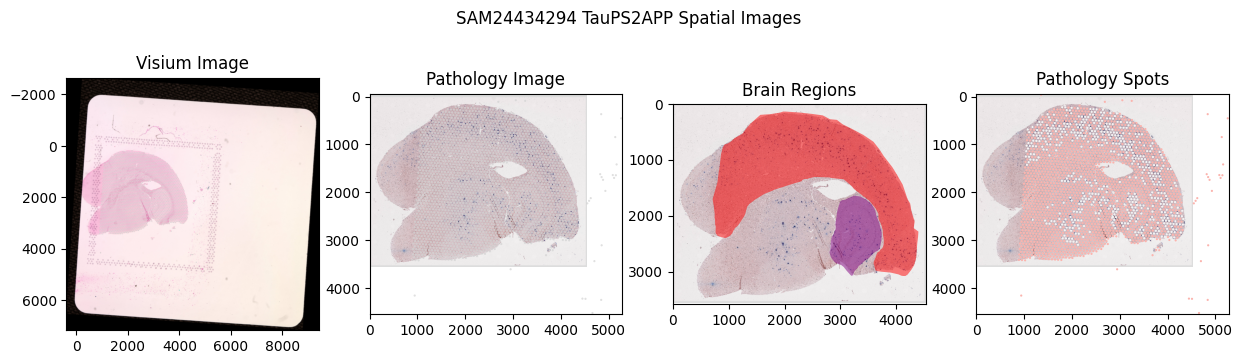

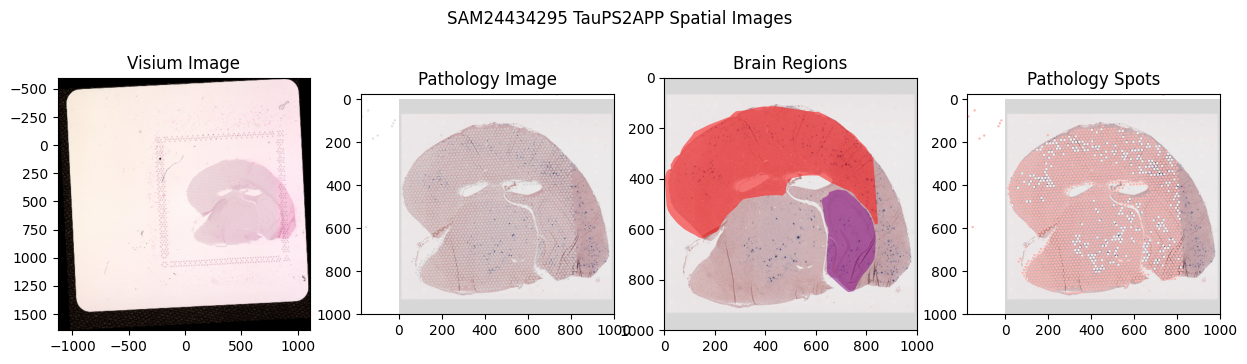

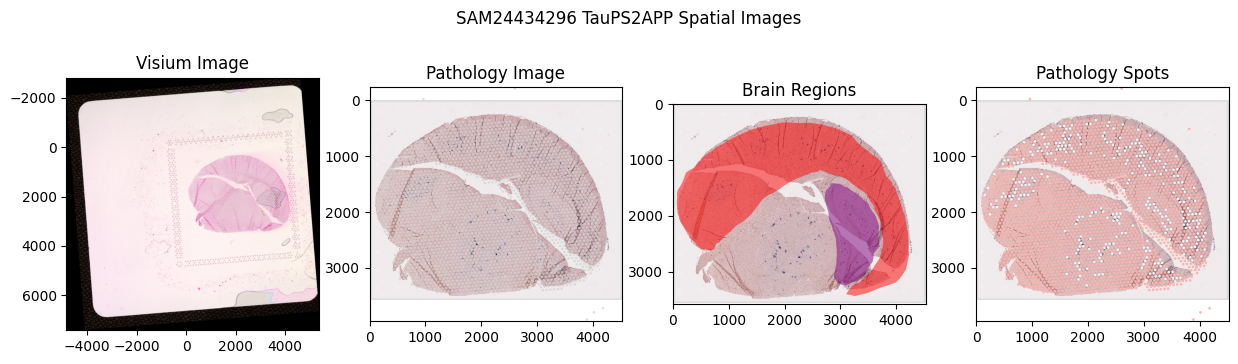

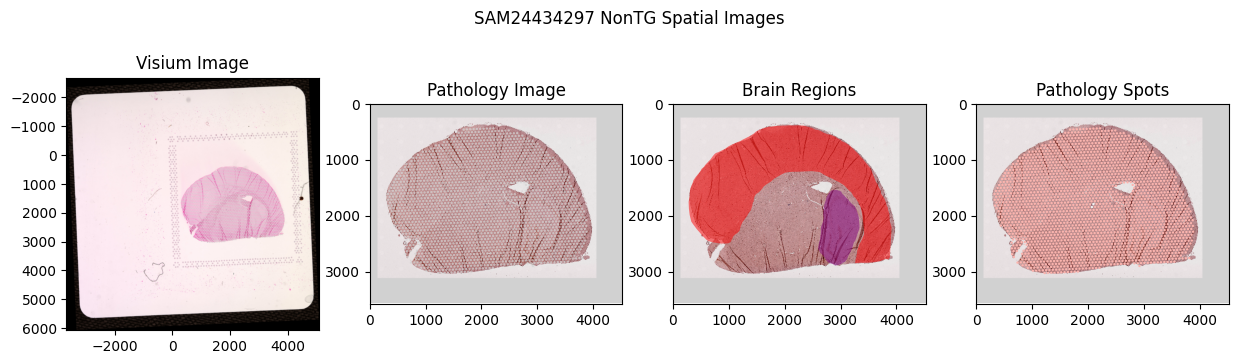

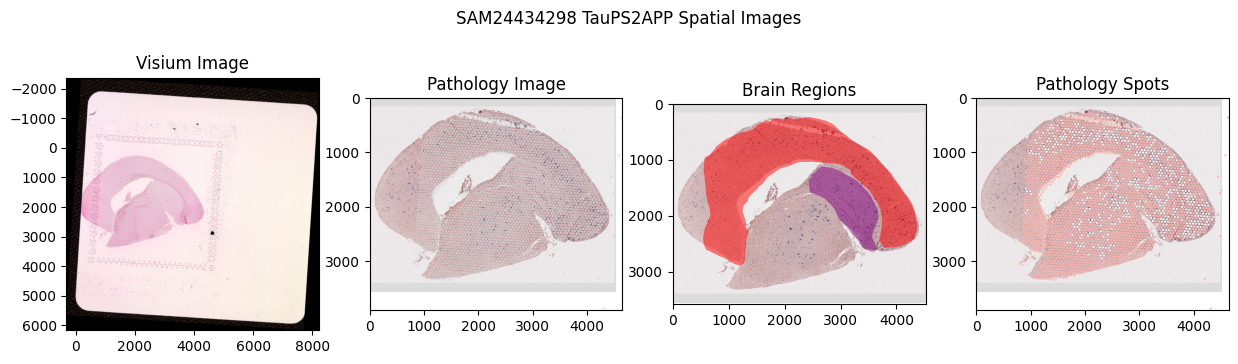

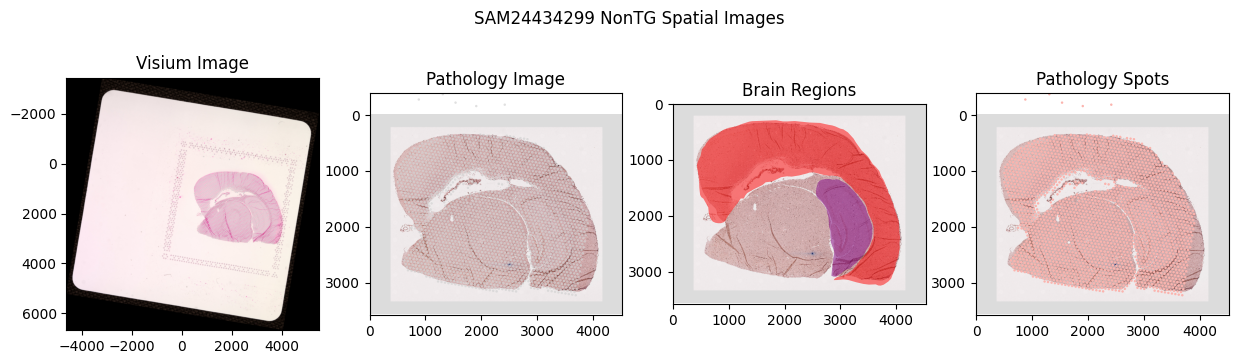

In [7]:
condition = ['TauPS2APP','TauPS2APP','TauPS2APP','NonTG','TauPS2APP','NonTG']

x=0
for dataset,cond in zip(datasets,condition):
    Hippocampus = sd.polygon_query(data_list[x],
        polygon=data_list[x].shapes["Hippocampus"]['geometry'][0],
        target_coordinate_system="downscaled_hires",
    )

    Cortex = sd.polygon_query(data_list[x],
        polygon=data_list[x].shapes["Cortex"]['geometry'][0],
        target_coordinate_system="downscaled_hires",
    )
    plaques = data_list[x].shapes["Abeta"].unary_union

    Abeta = sd.polygon_query(data_list[x],
        polygon=plaques,
        target_coordinate_system="aligned",
    )
    
    #Add Metadata
    data_list[x].table.obs['Cortex'] = data_list[x].table.obs.index.isin(Cortex.table.obs.index)
    data_list[x].table.obs['Hippocampus'] = data_list[x].table.obs.index.isin(Hippocampus.table.obs.index)
    data_list[x].table.obs['ContainsPathology'] = data_list[x].table.obs.index.isin(Abeta.table.obs.index)
    data_list[x].table.obs['BrainRegion'] = ['Other' if not (c1 or c2) else 
                         'Cortex' if c1 else
                         'Hipp' if c2 else
                         'both'
                         for c1, c2 in zip(data_list[x].table.obs['Cortex'], data_list[x].table.obs['Hippocampus'])]
    data_list[x].table.obs['Abeta'] = ['NoPathology' if not (c1 ) else 
                          'Abeta'
                          for c1 in data_list[x].table.obs['ContainsPathology']]
    
    
    # Let's plot regions and Abeta for each sample
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    data_list[x].pl.render_images(elements=f'{dataset}_hires_image').pl.render_shapes(elements=f'{dataset}',
                                                                                      fill_alpha=0.7,color='library').pl.show(ax=axs[0],
                                                                                                                              coordinate_systems="aligned",
                                                                                                                              title="Visium Image")
    data_list[x].pl.render_images(elements="AB").pl.render_shapes(elements=f'{dataset}',
                                                                  fill_alpha=0.7,
                                                                  color='library').pl.show(ax=axs[1],
                                                                                           coordinate_systems="aligned",
                                                                                           title="Pathology Image")

    Hippocampus.pl.render_shapes(elements="Hippocampus",color="purple",fill_alpha=0.5).pl.show(ax=axs[2],coordinate_systems="aligned", colorbar=True)
    Cortex.pl.render_shapes(elements="Cortex",color="red",fill_alpha=0.5).pl.show(ax=axs[2],coordinate_systems="aligned", colorbar=True)
    data_list[x].pl.render_images(elements="AB").pl.show(ax=axs[2],coordinate_systems="aligned",title="Brain Regions")

    data_list[x].pl.render_images(elements="AB").pl.render_shapes(elements=f'{dataset}',
                                                                  color="ContainsPathology",
                                                                  cmap="Pastel1").pl.show(ax=axs[3],
                                                                                          colorbar=False,
                                                                                          coordinate_systems="aligned",
                                                                                          title="Pathology Spots")
    fig.suptitle(' '.join([dataset.split("_")[1],cond,'Spatial Images']))
    x=x+1

# Save Spot data and updated SpatialData

In [8]:
# Write spot data to h5ad object so we can export to Seurat and scanpy later
x=0
for dataset in datasets:
    data_list[x].table.write_h5ad(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}_SpotData.h5ad')
    data_list[x].write(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}_updated.zarr')
    x=x+1

INFO     The Zarr file used for backing will now change from                                                       
         /Users/lucast3/Documents/VisiumAnalysis/data/LIB5472833_SAM24434294.zarr to                               
         /Users/lucast3/Documents/VisiumAnalysis/data/LIB5472833_SAM24434294_updated.zarr                          
INFO     The Zarr file used for backing will now change from                                                       
         /Users/lucast3/Documents/VisiumAnalysis/data/LIB5472834_SAM24434295.zarr to                               
         /Users/lucast3/Documents/VisiumAnalysis/data/LIB5472834_SAM24434295_updated.zarr                          
INFO     The Zarr file used for backing will now change from                                                       
         /Users/lucast3/Documents/VisiumAnalysis/data/LIB5472835_SAM24434296.zarr to                               
         /Users/lucast3/Documents/VisiumAnalysis/data/LIB5472835_SAM2443

In [9]:
data_list[0].table

AnnData object with n_obs × n_vars = 2336 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'Condition', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters', 'Cortex', 'Hippocampus', 'ContainsPathology', 'BrainRegion', 'Abeta'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'